<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Bayesian Modeling Lab</div>
<div style="text-align: right">Team 27, 21 February 2019</div>

# Lab: Posterior Predictive Checks on a Model


Let's build a Bayesian model for the Boston NBA team and study player rankings based on scores. 
#### The assumption is: If the score is above 500, the players qualify for the next game.


In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## Player rankings based on FG and AST of Boston NBA team 

A general goal of many statistical data analysis tasks is to relate the influence of one variable on another. Let's suppose *only* two factors count in a game of baseball: The Field Goals (FG), and the  The number of assists -- passes that lead directly to a made basket -- by a player (AST) of batters, leading to points scored.
We observe and collect data of 14 players:


In [11]:
game = pd.read_csv("C:/Users/Bibu/Documents/Northeastern/Data Science/Assignments/Assignment_5_Team_27/NBA_Bos1.csv",sep=",")
game

,FG,AST,PTS
0,379,337,952
1,213,140,520
2,359,121,894
3,3,3,10
4,95,33,262
5,682,449,2199
6,333,155,999
7,25,4,68
8,192,64,515
9,114,71,299


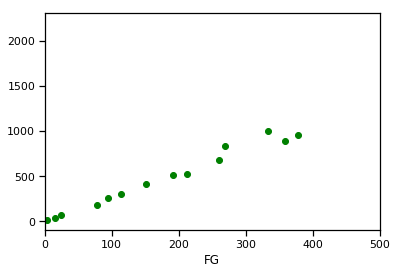

In [12]:
game.plot(x='FG', y='PTS', style='go', legend=False, xlim=(0,500));

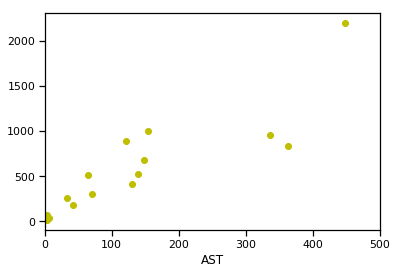

In [13]:
game.plot(x='AST', y='PTS', style='yo', legend=False, xlim=(0,500));

## 1. Linear sum of squares

Let's look at the general linear effect of FG and ASTs on the player scores. Let's build a linear predictive model (a line).

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible, as with our Vandermonde exercise in our linear algenra introduction notebook. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between modelled $\hat{y}$ and observed $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. to prevent positive and negative values from cancelling each other out
2. to strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model. Let's write the cost function:

In [14]:
sum_of_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x) ** 2)

However, we have the stated objective of minimizing the sum of squares, so we can pass this function to one of several optimizers in SciPy:

In [15]:
from scipy.optimize import fmin

x, z, y= game.T.values
x, z, y

(array([379, 213, 359,   3,  95, 682, 333,  25, 192, 114,  15, 260, 269,
        151,  78], dtype=int64),
 array([337, 140, 121,   3,  33, 449, 155,   4,  64,  71,   7, 148, 364,
        131,  42], dtype=int64),
 array([ 952,  520,  894,   10,  262, 2199,  999,   68,  515,  299,   38,
         678,  835,  410,  178], dtype=int64))

In [16]:
a0, a1 = fmin(sum_of_squares, [0,1], args=(x,y))
a0, a1

Optimization terminated successfully.
         Current function value: 97640.757012
         Iterations: 115
         Function evaluations: 211


(-57.53052299100044, 3.0681685573854036)

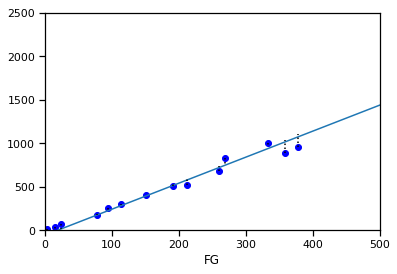

In [17]:
# goals in blue
ax = game.plot(x='FG', y='PTS', style='bo', legend=False, xlim=(0,500), ylim=(0, 2500))
ax.plot([0,2000], [a0, a0+a1*1950])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, a0+a1*xi], 'k:')

And now for the offense:

In [18]:
b0, b1 = fmin(sum_of_squares, [0,1], args=(z,y))
b0, b1

Optimization terminated successfully.
         Current function value: 1035611.517881
         Iterations: 102
         Function evaluations: 198


(107.53641600261919, 3.501186126413655)

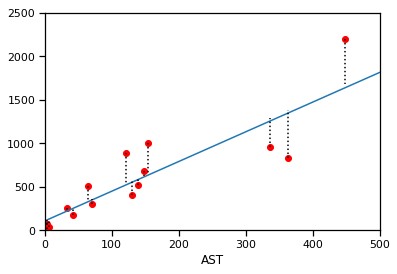

In [19]:
#assists in red
ax = game.plot(x='AST', y='PTS', style='ro', legend=False, xlim=(0,500), ylim=(0, 2500))
ax.plot([0,2000], [b0, b0+b1*1950])
for zi, yi in zip(z,y):
    ax.plot([zi]*2, [yi, b0+b1*zi], 'k:')

## 2. Bayesian Linear Regression with PyMC3

Let's trun to a Bayesian approach and build a regression model in PyMC3 for the games we just recorded.

### Likelihood

We'll pick a **normal** distribution of Points as our model, with a **mean** and **standard deviation** as parameters:

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

Here, $\mu_i$ is the expected value of the *i*th observation, which is generated by the regression model at the corresponding value of $x$. We calculate this expected value as a function of the regression parameters and the data.

We know that a Points outcome is most often modelled as a **Poisson distribution**, but here we'll use a Normal distribution instead. It may very well not work, the probabilistic computation may fail, your laptop may go up in smoke, but it;s the simplest possible thing we can do..

We score *observed* team strength with a single scalar value: ***Points***. However, the important parameters that will help the coach devise a winning strategy are *latent* (hidden). 

Let's assume one latent parameter $\theta$ as the following linear combination of:
- a constant (the bias)
- the FG of players
- the AST of players

So we write:

$$log(\theta) = \text{intercept} + \text{slope1} * \text{FG} + \text{slope2} * \text{AST}$$

We'll incorporate that latent parameter as the mean of the normal distribution model for ***Points***.

Let me stress: It should be a Poisson distribution instead (more appropriate for counts). But i'm using a Normal distribution, to simplify.

### Priors
The first step in specifying our model is to specify priors for our model.

Recall we use a linear model for μ, with an `intercept` (bias) factor and two linear factors `slope1` and `slope2` to represent ERA and RBI:

$$μ = \text{intercept} + \text{slope1}*x + \text{slope2}*z$$
    
We are going to model these factors as normal distributions with a *wide* support: 

$$\sim \text{Normal}(0, 100)$$

and finally the standard deviation of our modelled ***Points*** will be a **half Cauchy**:

$$\sigma \sim \text{HalfCauchy}(1)$$

The half-Cauchy distribution (half of a [Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution)) has support over positive continuous values, and relatively large tail probabilities, allowing for the possibility of extreme values. It is a very often used modeling pdf.

Since we want to track `slope1` and `slope2`, we need to add them as deterministic variables of our model: `pm.Deterministic`.

Ok, let's get cooking. We use `Deterministic` to track computed quantities inside the model. It is of no real use in the cell below, becayse if we don't specify `FG` and `AST`, slope1 and slope2 wouild be tracked anyway.

In [25]:
from pymc3 import Normal, HalfCauchy, Deterministic, Model

with Model() as game_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope1 = Normal('slope1', 0, sd=100)
    slope2 = Normal('slope2', 0, sd=100)
    FG = Deterministic('FG', slope1)
    AST = Deterministic('AST', slope2)
    σ = HalfCauchy('σ', 1)


You can find the C code in this temporary file: C:\Users\Bibu\AppData\Local\Temp\theano_compilation_error_qnbzl13q


AttributeError: module 'theano' has no attribute 'gof'

But here we want to track `μ`, so we set it equal to **deterministic** variable mu_d. What's the shape of mu_d?

In [ ]:
with game_model:
    
    μ = intercept + slope1*x + slope2*z
    mu_d = Deterministic('mu_d', μ)
    score = Normal('score', mu=μ, sd=σ, observed=y)

All right! Now your regression model is fully specified and you are ready to track your posteriors.

You can now use the fitting method of your choice to estimate a posterior distribution. Let's use a **Markov chain Monte Carlo** algorithm, called **NUTS** (the No U-Turn Sampler).

In [ ]:
from pymc3 import sample

with game_model:

    game_sample = sample(2000, random_seed=RANDOM_SEED)

Ok.. to be expected.. pymc3 tells us the results are not very good..

Let's plot posteriors anyway:

In [ ]:
from pymc3 import plot_posterior

plot_posterior(game_sample[500:], varnames=['intercept', 'FG', 'AST', 'σ', 'mu_d']);

We have 14 `mu_d`s above, one per game.

# Checking model fit

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to **simulate
data**, and the distribution of the simulated data should resemble the distribution of the actual data.

Sampling from the **posterior predictive distribution** is straighforward in PyMC3. The `sample_ppc` function draws posterior predictive checks from all of the data likelihoods. 

In [ ]:
from pymc3 import sample_ppc

with game_model:
    
    game_ppc = sample_ppc(game_sample, 1000)

This yields 1000 simulated games corresponding to each of the ten data points in our observation vector.

In [ ]:
game_ppc['score'].shape

We can then compare these simulated data to the data we used to fit the model. 

The model should prove that ***it*** could have been used to generate the game data that we observed.

We plot 14 histograms `hist`, one for each of the 1,000 simulations per game. Since each simulation yields different points per game, it makes sense that all these simulations put together yeild a histogram. We know see if the mean points per game for all 1,000 simulations matches the real score of each game, represented by a red line. 

In [ ]:
fig, axes = plt.subplots(5, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:], y, game_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

#axes_flat[-1].axis('off')
plt.tight_layout()

Ok, that looks pretty good.

Let's explore:

In [ ]:
game_ppc['score'][0]


In [ ]:
len(game_sample['σ'])

4000 points because 4 chains of 1000 points each. If you only have 2 processors on your laptop, you should have half that many points.

The [highest posterior density interval](highest posterior density interval) (HDI) is the shortest interval on a posterior density for some given confidence level. HDI has the nice property that any point **within** the interval has a higher density than any other point outside. Thus, the HPD interval is **the** collection of most likely values of a parameter.

What is the interval for the likely values for the ASTs?

In [ ]:
import pymc3 as pm
pm.stats.hpd(game_sample['AST'])

What is the interval for the likely values for the FGs?

In [ ]:
pm.stats.hpd(game_sample['FG'])

Quantiles are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The Median for example separates the two halves of a group. So players below the median AST *suck*, and those above it are *ok* :-)

In [ ]:
pm.stats.quantiles(game_sample['AST'])

In [ ]:
pm.stats.quantiles(game_sample['FG'])

Now let's collect our simulated latent parameters from the simulation, and build our theoretical model (which was verified to be "ok") with these parameters. The parameters now drive the score, which is what we want.

Since the score is a normal distribution, we enter its mean and its standard deviation as modelled:

In [ ]:
ASTs = game_sample['AST']
FGs = game_sample['FG']
intercepts = game_sample['intercept']
sig = game_sample['σ']
# assuming x = z = 1
score_samples = Normal.dist(intercepts + FGs + ASTs, sig).random()

In [ ]:
len(score_samples)

The mean of the ASTs for the simulation is:

In [ ]:
ASTs.mean()

The mean probability that the team that played the 10 observed games actually wins is above 75%. Pretty good!

In [ ]:
(score_samples > 0.2).mean()

Now let's pretend we're a coach and let's do some game analytics.

<img src="http://www.knowitalljoe.com/wp-content/uploads/2016/01/Star-Wars-Calvin-and-Hobbes-Mashup-1.jpg" width=300>

What happens if we increase the ASTs by 30% (better pitchers)?

In [ ]:
z_score = 1 + 0.3
higher_asts = ASTs * z_score
higher_asts.mean()

Let's evaluate the new scores based on our model:

In [ ]:
new_score_samples = Normal.dist(intercepts + FGs + higher_asts, sig).random()

And what's the probability of qualifying for next game *now*?

In [ ]:
(new_score_samples > 0.2).mean()

What happens if we **increase** the FG by 30%?

In [ ]:
x_score = 1 + 0.3
higher_fgs = FGs * x_score
higher_fgs.mean()

Let's evaluate the new scores based on our model:

In [ ]:
new2_score_samples = Normal.dist(intercepts + higher_fgs + ASTs, sig).random()

And what's the probability of qualifying for the next game *now*?

In [ ]:
(new2_score_samples > 0.2).mean()

This shows that , the probability of qualifying for the next game has increased when we increase FG by 30%


In [ ]:
d = {'FG': FGs[3990:],'AST': ASTs[3990:],'Points':score_samples[3990:]}
pd.DataFrame(d)